In [1]:
import sys
import pickle
sys.path.insert(0,'..')

from causalmodel.interference import Clustered
from causalmodel.utils.random_data import get_data, get_fixed_cluster, get_clustered_data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def one_trial():
    Y, Z, X, labels = get_clustered_data(Ms=[5000,5000,2000], ns=[2,3,5])
    c = Clustered(Y, Z, X, labels)
    result = c.est_via_aipw()
    return [(beta_g - 1 - 0.1*g)/result['se'][g] for g, beta_g in enumerate(result['beta(g)'])]

print(one_trial())

[-0.744851385170611, -0.782804681646602, -0.7615340392272274, -1.6855007631426948, -3.148361040029874]


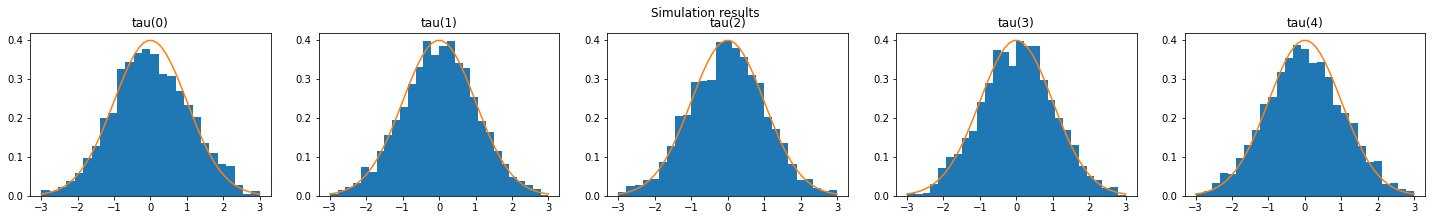

In [6]:
def simulate(n=100):
    return list(zip(*[one_trial() for i in range(n)]))


def plot(z, title):
    fig = plt.figure(figsize=(5*len(z),3))
    for i, zs in enumerate(z):
        plt.subplot(1, len(z), i+1)
        plt.hist(zs, range=(-3,3), density=True, bins='auto')
        x = np.linspace(-3,3)
        pdf = norm.pdf(x)
        plt.plot(x,pdf)
        plt.title("tau({})".format(i))
    plt.suptitle(title, y=1)
    plt.show()

results = simulate(2000)
with open('interference_simulation.pkl', 'wb') as fp:
    pickle.dump(results, fp)
plot(results, "Simulation results")

In [ ]:
def com_aipw_ols():
    Y, Z, X, labels = get_clustered_data(Ms=[5000,5000,2000], ns=[2,3,5])
    c = Clustered(Y, Z, X, labels)
    result1 = c.est_via_aipw()
    result2 = c.est_via_ols()
    return result1, result2

def simulate(n=10):
    beta_aipw, beta_ols, se_aipw, se_ols = [], [], [], []
    gs = 1 + 0.1*np.arange(5)
    for i in range(n):
        ret1, ret2 = com_aipw_ols()
        beta_aipw.append(list(ret1['beta(g)']-gs))
        beta_ols.append(list(ret2['beta(g)']-gs))
        se_aipw.append(list(ret1['se']))
        se_ols.append(list(ret2['se']))
    return list(zip(*beta_aipw)), list(zip(*beta_ols)), list(zip(*se_aipw)), list(zip(*se_ols))

def plot_comp(betas):
    fig = plt.figure(figsize=(5*len(betas[0]),3))
    plt.suptitle("AIPW", y=1)
    for i, bs in enumerate(betas[0]):
        plt.subplot(1, len(betas[0]), i+1)
        plt.hist(bs, density=True, bins='auto')
        plt.title("tau({})".format(i))
    plt.show()
    fig = plt.figure(figsize=(5*len(betas[0]),3))
    plt.suptitle("OLS", y=1)
    for i, bs in enumerate(betas[1]):
        plt.subplot(1, len(betas[1]), i+1)
        plt.hist(bs, density=True, bins='auto')
        plt.title("tau({})".format(i))
    plt.show()

results = simulate(2000)
with open('interference_simulation_ols_vs_aipw.pkl', 'wb') as fp:
    pickle.dump(results, fp)
plot_comp(results)

In [13]:
data = np.load('interference_simulation_ols_vs_aipw.pkl', allow_pickle=True)
beta_aipw, beta_ols, se_aipw, se_ols = data

beta_aipw = np.array(beta_aipw[0])
beta_ols = np.array(beta_ols[0])
se_aipw = np.array(se_aipw[0])
se_ols = np.array(se_ols[0])

bound_aipw = 1.96*se_aipw
bound_ols = 1.96*se_ols

cover_aipw = np.abs(beta_aipw) < bound_aipw
cover_ols = np.abs(beta_ols) < bound_ols

print("cover rate for AIPW: ", np.mean(cover_aipw))
print("cover rate for OLS: ", np.mean(cover_ols))

cover rate for AIPW:  0.933
cover rate for OLS:  0.633


### Non-linear outcome models

In [2]:
def get_data_nonlinear1(tau=1, gamma=0.1):
    y, Z, X, labels, G, Xc = get_fixed_cluster(N=20000, M=5000, get_G=True)
    epsilon = np.random.normal(0, 1, len(Z))
    Y = tau*Z + Xc.dot(np.linspace(-1,1,Xc.shape[1])) + gamma * G *Z + gamma**2 * (G**2) * Z + epsilon
    return Y, Z, X, labels

def get_data_nonlinear2(tau=1, gamma=0.1):
    y, Z, X, labels, G, Xc = get_fixed_cluster(N=20000, M=5000, get_G=True)
    epsilon = np.random.normal(0, 1, len(Z))
    Y = tau*Z + Xc.dot(np.linspace(-1,1,Xc.shape[1])) + gamma * 1/(G+1) *Z + epsilon
    return Y, Z, X, labels

def get_data_nonlinear3(tau=1, gamma=0.1):
    y, Z, X, labels, G, Xc = get_fixed_cluster(N=20000, M=5000, get_G=True)
    epsilon = np.random.normal(0, 1, len(Z))
    Y = tau*Z + Xc.dot(np.linspace(-1,1,Xc.shape[1])) + gamma * np.sqrt(G) *Z + epsilon
    return Y, Z, X, labels

def get_data_linear():
    y, Z, X, labels, G, Xc = get_fixed_cluster(N=20000, M=5000, get_G=True)
    return y, Z, X, labels


def com_aipw_ols(Y, Z, X, labels):
    c = Clustered(Y, Z, X, labels)
    result1 = c.est_via_aipw()
    result2 = c.est_via_ols()
    return result1, result2

def cover_rate(gs, get_data, n=2000):
    beta_aipw, beta_ols, se_aipw, se_ols = [], [], [], []
    for i in range(n):
        Y, Z, X, labels = get_data()
        ret1, ret2 = com_aipw_ols(Y, Z, X, labels)
        beta_aipw.append(list(ret1['beta(g)']-gs))
        beta_ols.append(list(ret2['beta(g)']-gs))
        se_aipw.append(list(ret1['se']))
        se_ols.append(list(ret2['se']))
    beta_aipw, beta_ols, se_aipw, se_ols = list(zip(*beta_aipw)), list(zip(*beta_ols)), list(zip(*se_aipw)), list(zip(*se_ols))
    cover_aipws, cover_olss = [], []
    for g in range(len(beta_aipw)):
        beta_aipw_g = np.array(beta_aipw[g])
        beta_ols_g = np.array(beta_ols[g])
        se_aipw_g = np.array(se_aipw[g])
        se_ols_g = np.array(se_ols[g])
    
        bound_aipw = 1.96*se_aipw_g
        bound_ols = 1.96*se_ols_g
    
        cover_aipw = np.abs(beta_aipw_g) < bound_aipw
        cover_ols = np.abs(beta_ols_g) < bound_ols
        
        cover_aipws.append(np.mean(cover_aipw))
        cover_olss.append(np.mean(cover_ols))
    
    print("cover rate for AIPW: ", np.mean(cover_aipws))
    print("cover rate for OLS: ", np.mean(cover_olss))
    return cover_aipws, cover_olss

def simulate1(n_trails):
    gs = 1 + 0.1*np.arange(4) + 0.01*(np.arange(4)**2)
    return cover_rate(gs, get_data_nonlinear1, n=n_trails)

def simulate2(n_trails):
    gs = 1 + 0.1*(1/(np.arange(4)+1))
    return cover_rate(gs, get_data_nonlinear2, n=n_trails)

def simulate3(n_trails):
    gs = 1 + 0.1*np.sqrt(np.arange(4))
    return cover_rate(gs, get_data_nonlinear3, n=n_trails)

cover_aipw1, cover_ols1 = simulate1(500)
cover_aipw2, cover_ols2 = simulate2(500)
cover_aipw3, cover_ols3 = simulate3(500)

cover rate for AIPW:  0.936
cover rate for OLS:  0.9015
cover rate for AIPW:  0.9414999999999999
cover rate for OLS:  0.9029999999999999
cover rate for AIPW:  0.9420000000000001
cover rate for OLS:  0.7905


In [3]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from econml.orf import DROrthoForest as CausalForest

def com_forest(Y, Z, X, labels):
    c = Clustered(Y, Z, X, labels)
    forest = CausalForest(n_trees=10, max_depth=5, verbose=0,
                         propensity_model=sklearn.linear_model.LogisticRegression(),
                         model_Y=sklearn.linear_model.LinearRegression())
    Y, Z, G, Xc, labels = c.data.data_by_size[4]
    forest.fit(Y, Z, X=G.reshape(-1, 1), W=Xc)
    result_forest = {'beta(g)': forest.effect(np.arange(len(set(G))).reshape(-1, 1)),
                     'cf(g)':forest.effect_interval(np.arange(len(set(G))).reshape(-1, 1))}
    #result_ols = c.est_via_ols()
    return result_forest

Y, Z, X, labels = get_data_nonlinear3()
Y, Z, X, labels, G, Xc = get_fixed_cluster(N=40000, get_G=True)
com_forest(Y, Z, X, labels)

{'beta(g)': array([1.00109578, 1.08877448, 1.17579972, 1.31550304]),
 'cf(g)': (array([0.86176171, 1.02356444, 1.12625438, 1.21008187]),
  array([1.14042986, 1.15398453, 1.22534506, 1.42092421]))}

In [4]:
def cover_rate_forest(gs, get_data, n=2000):
    cover = np.zeros((n,len(gs)))
    for i in range(n):
        cfi = com_forest(Y, Z, X, labels)['cf(g)']
        for g in range(len(gs)):
            if gs[g] <= cfi[1][g] and gs[g] >= cfi[0][g]:
                cover[i,g] = 1
    print("cover rate for Causal Forest: ", np.mean(cover))
    return np.mean(cover, axis=0)

def simulate1_forest(n_trails):
    gs = 1 + 0.1*np.arange(4) + 0.01*(np.arange(4)**2)
    return cover_rate_forest(gs, get_data_nonlinear1, n=n_trails)

def simulate2_forest(n_trails):
    gs = 1 + 0.1*(1/(np.arange(4)+1))
    return cover_rate_forest(gs, get_data_nonlinear2, n=n_trails)

def simulate3_forest(n_trails):
    gs = 1 + 0.1*np.sqrt(np.arange(4))
    return cover_rate_forest(gs, get_data_nonlinear3, n=n_trails)

def simulate4_forest(n_trails):
    gs = 1 + 0.1*np.arange(4)
    return cover_rate_forest(gs, get_data_linear, n=n_trails)

cover_forest1 = simulate1_forest(500)
cover_forest2 = simulate2_forest(500)
cover_forest3 = simulate3_forest(500)
cover_forest4 = simulate4_forest(500)

cover rate for Causal Forest:  0.9115
cover rate for Causal Forest:  0.342
cover rate for Causal Forest:  0.679
cover rate for Causal Forest:  0.988


In [2]:
def get_fixed_cluster_continuous(N=30000, M=10000, k=2, tau=1, gamma=0.1, label_start=0,
                      get_G=False):
    """
    Get data for fixed cluster size.

    Parameters
    ----------
    N : int, optional
        Number of units. The default is 30000.
    M : int, optional
        Number of clusters. The default is 10000.
    k : int, optional
        Number of features. The default is 2.
    tau : float, optional
        Amount of direct treatment effect. The default is 1.
    gamma : float, optional
        Amount of spillover effect. The default is 0.1.
    label_start : int, optional
        The beginning index for cluster labels. The default is 0.
    get_G : Boolean, optional
        Output G if True
    """
    n = int(N/M)
    # get clustering labels
    labels = np.array(list(np.arange(M))*n) + label_start
    labels = np.sort(labels)
    # get covariates
    X = np.random.multivariate_normal(np.zeros(k), np.diag(np.ones(k)), (M, n))*0.1
    Xc = np.zeros((M, n, k*2))
    Xcmean = np.mean(X, axis=1).reshape((M, 1, k))
    Xc[:,:,:k] = X.reshape((M, n, k))
    Xc[:,:,k:] = np.repeat(Xcmean, n, axis=1)
    X = X.reshape(N, k)
    Xc = Xc.reshape(N, k*2)
    # get treatment
    Z = Xc.dot(np.linspace(-1,1,2*k)) + np.random.normal(0, 1, N)
    # get G, number of treated neighbours
    Z_stack = Z.reshape(M, n)
    G_plus = np.repeat(np.sum(Z_stack, axis=1).reshape(M, 1), n, axis=1)
    G_stack = G_plus - Z_stack
    G = G_stack.reshape(N)
    # get outcome Y
    epsilon = np.random.normal(0, 1, N)
    Y = tau*Z + Xc.dot(np.linspace(-1,1,2*k)) + gamma * G *Z + epsilon
    sub = np.random.choice(np.arange(N), N, replace=False)
    if get_G:
        return Y[sub], Z[sub], X[sub], labels[sub], G[sub], Xc[sub]
    return Y[sub], Z[sub], X[sub], labels[sub]

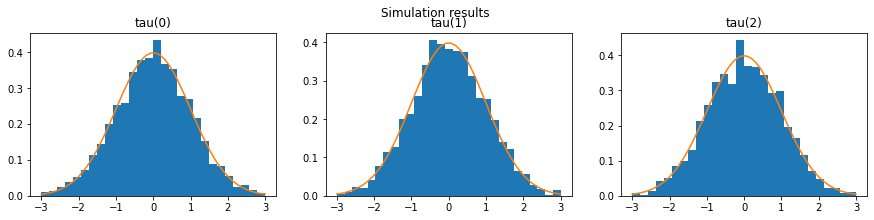

In [3]:
def one_trial_dml():
    Y, Z, X, labels = get_fixed_cluster_continuous()
    c = Clustered(Y, Z, X, labels, categorical_Z=False)
    result = c.est_via_dml()
    return [(beta_g - 1 - 0.1*g)/result['se'][g] for g, beta_g in enumerate(result['beta(g)'])]

def simulate_dml(n=100):
    return list(zip(*[one_trial_dml() for i in range(n)]))

def plot(z, title):
    fig = plt.figure(figsize=(5*len(z),3))
    for i, zs in enumerate(z):
        plt.subplot(1, len(z), i+1)
        plt.hist(zs, range=(-3,3), density=True, bins='auto')
        x = np.linspace(-3,3)
        pdf = norm.pdf(x)
        plt.plot(x,pdf)
        plt.title("tau({})".format(i))
    plt.suptitle(title, y=1)
    plt.show()

results = simulate_dml(2000)
with open('interference_dml_simulation.pkl', 'wb') as fp:
    pickle.dump(results, fp)
plot(results, "Simulation results")